In [1]:
import numpy as np
import pandas as pd

from policy import Policy
from car import *
from person import *
from environment import Environment
from policy import *

import shapely
import matplotlib
from matplotlib import pylab as plt
import rtree
import geopandas as gpd
import pyproj
import contextily as ctx
import overpy

from shapely.geometry import Point, LineString, Polygon, GeometryCollection
from shapely.ops import polygonize
from shapely.wkt import loads as wkt_load

from tempfile import mkstemp

%load_ext autoreload
%autoreload 2

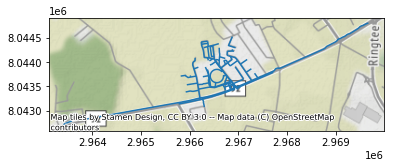

In [2]:
crs_gps = pyproj.CRS.from_epsg('4326')
crs_web = pyproj.CRS.from_epsg('3857')

req = '''area["name"="Märja alevik"]->.a;
  ( node(area.a)["highway"];
    way(area.a)["highway"];
    rel(area.a)["highway"];
  );
  out body;
  >;
  out;
'''

overpass_api = overpy.Overpass()
rsp = overpass_api.query(req)

df_nodes =\
pd.DataFrame([dict([(a,getattr(x,a)) for a in ['id','lat','lon']]) for x in rsp.nodes]).set_index('id',drop=True)
df_nodes

df_ways =\
pd.DataFrame(np.vstack([np.asarray([[w.id, n.id] for n in w.nodes]) for w in rsp.ways]),columns=['id','node'])\
    .set_index('id', drop=True)
df_ways

df_way_lines =\
df_ways.join(df_nodes, on='node')\
    .groupby('id')\
    .apply(lambda df_way: LineString(df_way[['lon','lat']].values))
df_way_lines

gdf_ways = gpd.GeoDataFrame(df_way_lines.index,
                            geometry=df_way_lines.values,
                            crs=crs_gps).set_index('id', drop=True)\
    .to_crs(crs=crs_web)
gdf_ways

fig,ax = plt.subplots(1,1)
gdf_ways.plot(ax=ax)
ctx.add_basemap(ax=ax, zoom=13)

In [3]:
df_edges =\
df_ways.reset_index(drop=False).groupby('id').apply(
    lambda df_nodes: pd.DataFrame(
        np.vstack([df_nodes.node.values[:-1],
                   df_nodes.node.values[1:]]).T))\
    .rename(columns={0:'vtx1',1:'vtx2'})
df_edges
gdf_nodes =\
gpd.GeoDataFrame(
    df_nodes.index,
    geometry=[Point(p) for p in df_nodes[['lon','lat']].values],
    crs=crs_gps).to_crs(crs=crs_web).set_index('id', drop=True)
gdf_nodes

ptx,pty =\
np.array([p.xy for p in gdf_nodes.geometry.values]).reshape(-1,2).T
gdf_nodes['x'] = ptx
gdf_nodes['y'] = pty

src = gdf_nodes.loc[df_edges.vtx1.values][['x','y']].values
dst = gdf_nodes.loc[df_edges.vtx2.values][['x','y']].values

index1 = [(v1, v2) for v1, v2 in zip(df_edges.vtx1.values, df_edges.vtx2.values)]
index2 = [(v2, v1) for v1, v2 in zip(df_edges.vtx1.values, df_edges.vtx2.values)]
df_edges = pd.concat((
    pd.DataFrame({'dst': np.linalg.norm(src-dst, axis=1)}, index=index1), 
    pd.DataFrame({'dst': np.linalg.norm(src-dst, axis=1)}, index=index2), 
))

In [4]:
distances = pd.DataFrame(
    {'dst': [df_edges.loc[[(v1, v2)]]['dst'].values[0] if (v1, v2) in df_edges.index else np.inf for v1 in df_nodes.index for v2 in df_nodes.index]}, 
    index=[(v1, v2) for v1 in df_nodes.index for v2 in df_nodes.index]
)

In [5]:
from tqdm.notebook import tqdm

distances = {(v1, v2): df_edges.loc[[(v1, v2)]]['dst'].values[0] if (v1, v2) in df_edges.index else np.inf for v1 in df_nodes.index for v2 in df_nodes.index}
for v in df_nodes.index:
    distances[v, v] = 0

for k in tqdm(df_nodes.index):
    for v1 in df_nodes.index:
        for v2 in df_nodes.index:
            distances[v1, v2] = min(
                distances[v1, v2], 
                distances[v1, k] + distances[k, v2]
            )

In [6]:
np.unique(list(distances.values()), return_counts=True)

(array([0.00000000e+00, 2.20796573e+00, 3.18159369e+00, ...,
        6.77284723e+03, 6.79198181e+03,            inf]),
 array([ 408,    2,    2, ...,    2,    2, 4848]))

In [7]:
to_drop_v = set()
for v1 in df_nodes.index:
    count = 0
    for v2 in df_nodes.index:
        if distances[v1, v2] == np.inf:
            count += 1
    if count > 350:
        to_drop_v.add(v1)
to_drop_e = []
for v1, v2 in distances:
    if {v1, v2} & to_drop_v:
        to_drop_e.append((v1, v2))
for pair in to_drop_e:
    del distances[pair]
df_nodes = df_nodes.drop(to_drop_v)

In [8]:
time = 0
car_proba  = 0.01
pers_proba = 0.05
nodes = df_nodes.index

car_f = CarFactory()
per_f = PersonFactory()

cars = [car_f.generate_car(nodes, time)]
people = [per_f.generate_person(nodes, time), per_f.generate_person(nodes, time)]

policy = ClosestPolicy(cars, people, distances)
environment = Environment(cars, people, policy, distances)

while time <= 10 ** 4:
    if np.random.rand() < car_proba:
        cars.append(car_f.generate_car(nodes, time))
    if np.random.rand() < pers_proba:
        people.append(per_f.generate_person(nodes, time))
    environment.step(time, distances)
    time += 1
    if time % 1000 == 0:
        print(time, 'time units passed')

1000 time units passed
2000 time units passed
3000 time units passed
4000 time units passed
5000 time units passed
6000 time units passed
7000 time units passed
8000 time units passed
9000 time units passed
10000 time units passed


In [9]:
stats, ratio = environment.stats()

In [10]:
stats.mean()

assigning     407.359322
waiting       345.338983
riding       1823.494915
dtype: float64

In [11]:
ratio

0.5807086614173228